### Initial setup

In [1]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import arviz as az
import pymc3 as pm

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
#Read data
data = pd.read_csv('/Users/nicospinu/bayesian-dnt/machine_readable_dnt.csv')

In [3]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data[['DNT']]).values

In [5]:
# ### Mask missing values

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(y_dnt)
Y_dnt_train = np.ma.masked_array(y_dnt, mask=y_dnt_missing)

### Define and fit the model

In [6]:
with pm.Model() as hierar_model:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [7]:
# ## Define bndf 
with hierar_model: 
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', mu=Xmu_bdnf, sd=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [8]:
# ## Define syn
with hierar_model:
    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p = lp_syn, observed=Y_syn_train)

In [9]:
# ## Define nnf
with hierar_model:
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [10]:
# ## Define DNT
with hierar_model:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [11]:
#Checking the proposed structure of model
hierar_model.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                  -13.82
beta_syn                    -4.61
beta_nnf                    -6.91
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     -2.76
Xsigma_nnf_log__            -2.31
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -863.18
y_obs_bdnf                 -67.24
X_syn_modelled            -295.25
y_obs_syn                  -67.24
X_nnf_modelled            -452.70
y_obs_nnf                  -67.24
y_obs_dnt                  -67.24
Name: Log-probability of test_point, dtype: float64

In [12]:
#Compute prior distribution

#ERROR related to shape

with hierar_model:
    prior_all = pm.sample_prior_predictive(1000)

ValueError: shape mismatch: value array of shape (6,) could not be broadcast to indexing result of shape (115,)
Apply node that caused the error: AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True}(TensorConstant{[[-8.71893..0000e+20]]}, X_bdnf_modelled_missing, TensorConstant{[24 24 24 .. 96 96 96]}, TensorConstant{[1 3 4 5 0..
 2 3 4 5]})
Toposort index: 1
Inputs types: [TensorType(float64, matrix), TensorType(float64, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(97, 6), (6,), (115,), (115,)]
Inputs strides: [(8, 776), (8,), (16,), (16,)]
Inputs values: ['not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, X_bdnf_modelled, InplaceDimShuffle{0}.0, TensorConstant{0.0})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3071, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-7064cc67e4e0>", line 6, in <module>
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', mu=Xmu_bdnf, sd=Xsigma_bdnf, observed=X_bdnf_train)
  File "/opt/anaconda3/lib/python3.8/site-packages/pymc3/distributions/distribution.py", line 83, in __new__
    return model.Var(name, dist, data, total_size, dims=dims)
  File "/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py", line 1112, in Var
    var = ObservedRV(
  File "/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py", line 1737, in __init__
    data = as_tensor(data, name, model, distribution)
  File "/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py", line 1683, in as_tensor
    dataTensor = tt.set_subtensor(constant[data.mask.nonzero()], missing_values)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [13]:
#Make the inferences
with hierar_model:
    trace = pm.sample(cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


In [14]:
#Compute posterior distributions
with hierar_model:
    posterior_all = pm.sample_posterior_predictive(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa99262160>,
      dtype=object)

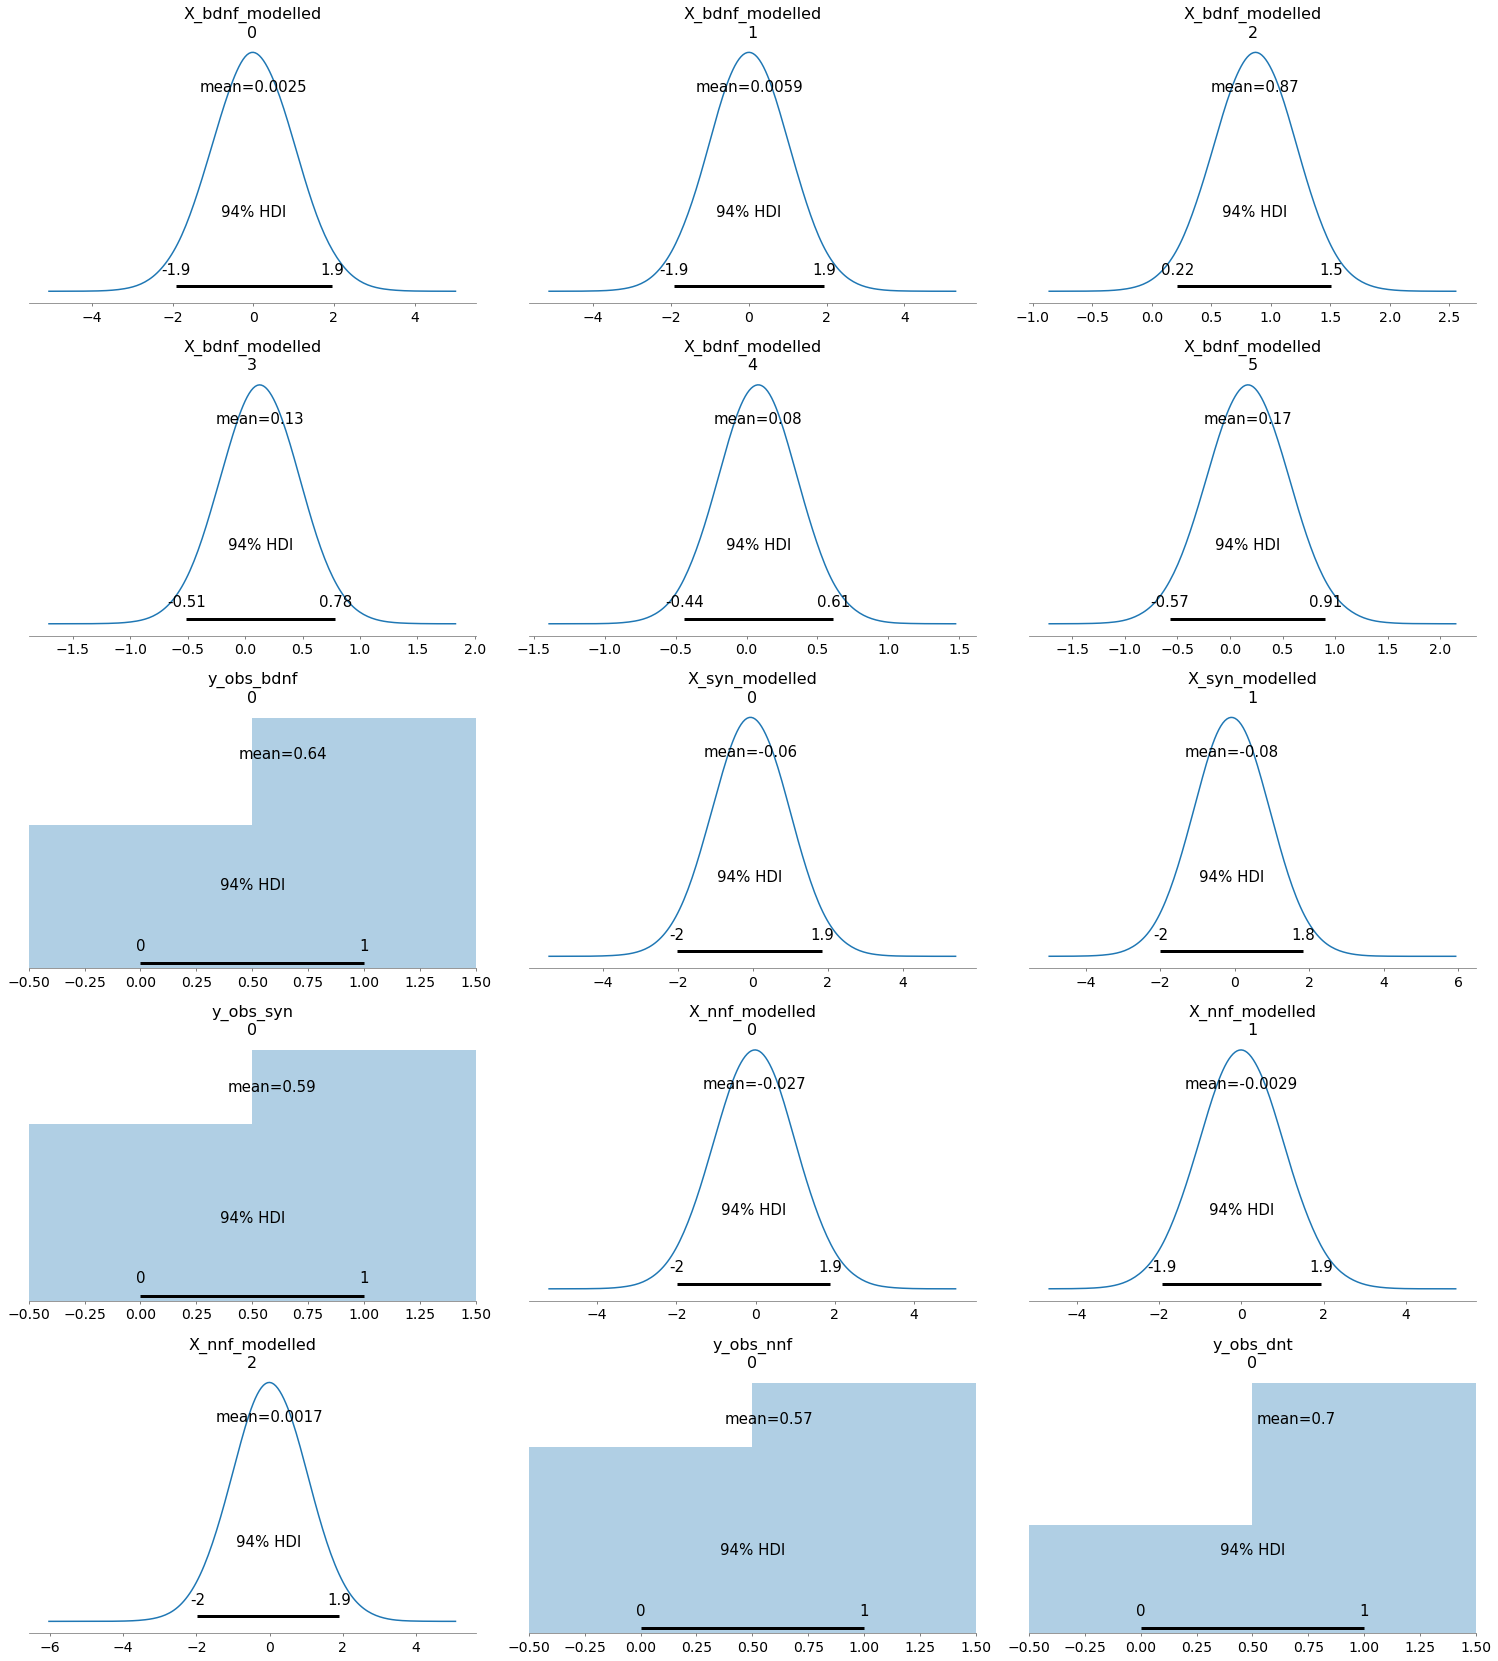

In [15]:
#Checking the posterior
pm.plot_posterior(posterior_all)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa973bb250>],
      dtype=object)

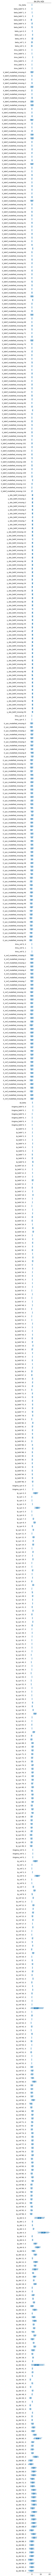

In [16]:
pm.forestplot(trace)

### Model checking

Text(0.5, 1.0, 'BFMI = 0.9048864934091486\nGelman-Rubin = 1.0072566146517978')

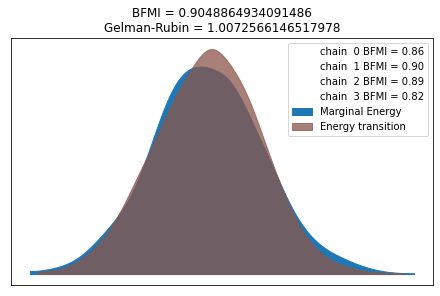

In [17]:
#Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
(pm.energyplot(trace, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)))

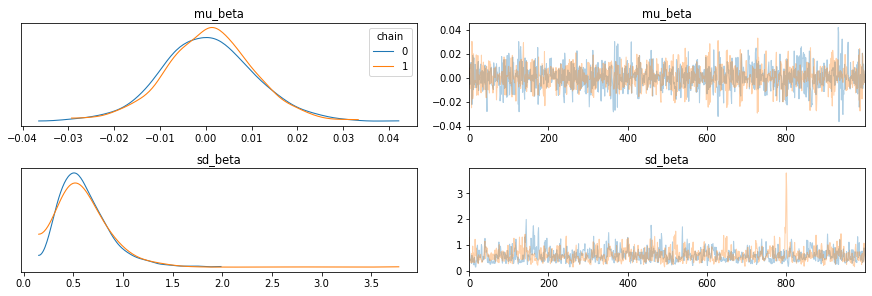

In [18]:
#Check convergence for hyperpriors of two chains
az.plot_trace(trace, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa8187f490>,
      dtype=object)

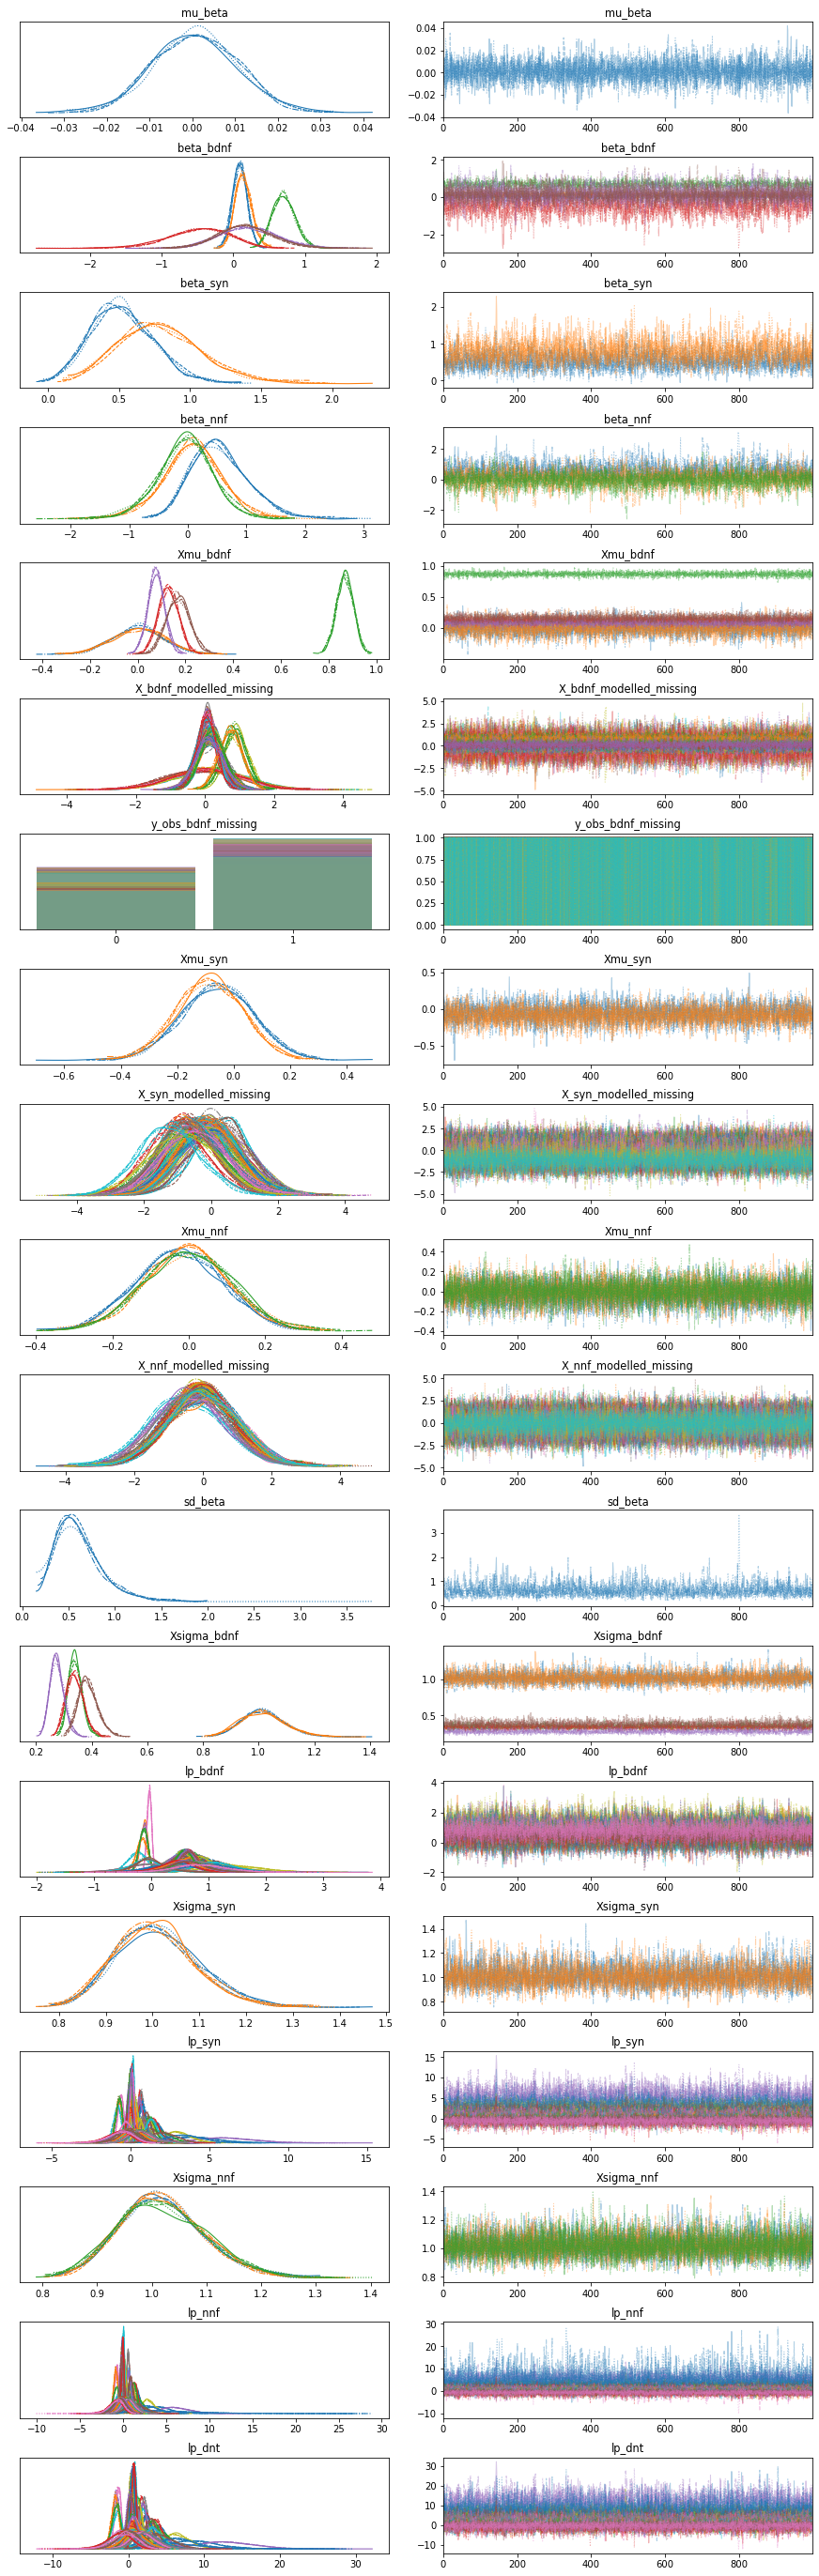

In [19]:
#Check the convergence of all parameters
pm.traceplot(trace)

### Checking statistics

In [20]:
#Statistical summary
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.001,0.010,-0.017,0.019,0.000,0.000,5736.0,1394.0,5769.0,2493.0,1.0
"beta_bdnf[0,0]",0.094,0.099,-0.101,0.274,0.002,0.001,3438.0,2673.0,3448.0,2710.0,1.0
"beta_bdnf[1,0]",0.144,0.117,-0.072,0.363,0.002,0.002,3136.0,2723.0,3251.0,2895.0,1.0
"beta_bdnf[2,0]",0.711,0.156,0.413,0.994,0.004,0.003,1476.0,1438.0,1506.0,2017.0,1.0
"beta_bdnf[3,0]",-0.485,0.438,-1.267,0.320,0.012,0.009,1380.0,1249.0,1463.0,1786.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"lp_dnt[92,0]",-0.012,1.476,-2.769,2.660,0.023,0.023,4037.0,2078.0,4062.0,2990.0,1.0
"lp_dnt[93,0]",-1.359,1.689,-4.530,1.623,0.027,0.021,3786.0,3158.0,3843.0,3141.0,1.0
"lp_dnt[94,0]",0.012,1.490,-3.076,2.643,0.023,0.024,4162.0,1986.0,4271.0,2829.0,1.0
"lp_dnt[95,0]",-0.007,1.474,-2.942,2.582,0.022,0.022,4458.0,2328.0,4495.0,3199.0,1.0


In [21]:
#Helper function
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="#1f77b4", ec="#3d5167", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

In [22]:
#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    #ax.set_xlabel("Rhat statistic", labelpad=15)
    ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.05:
None



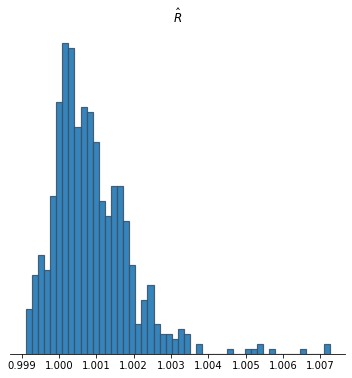

In [23]:
check_rhat(trace, threshold=1.05) #1.005 also considered
plt.show()

In [24]:
#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    #ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None



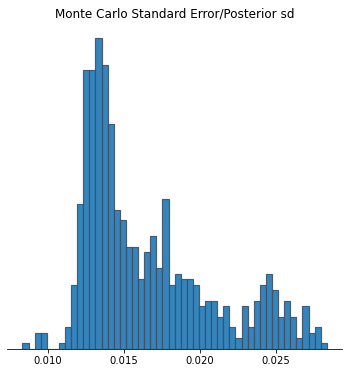

In [25]:
check_mcse(trace)
plt.show()

In [26]:
#Error related to the shape of bdnf


#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    #ax.set_xlabel("Effective sample size / iterations", labelpad=15)
    ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



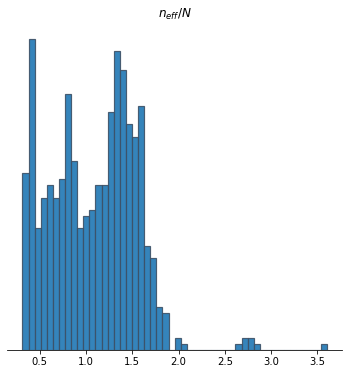

In [27]:
check_neff(trace)
plt.show()

### Goodness of fit

In [29]:
#Plot the observed vs simulated and mean

#ERROR related to strace or report

data = az.from_pymc3(trace, posterior_predictive=posterior_all, model = hierar_model) #prior=prior_all
az.plot_ppc(data);

AttributeError: 'InferenceData' object has no attribute 'report'

### Predictions

In [ ]:
bdnf = trace['y_obs_bdnf']
syn = trace['']
nnf = trace['']
dnt = trace['']

In [ ]:
#Helper function
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
post_bdnf = logistic(bdnf)
post_syn
post_nnf
post_dnt


In [ ]:

#https://seaborn.pydata.org/examples/pairgrid_dotplot.html
    

### Save the graphical structure, stats and traces

In [ ]:
#Save the graphical structure of the model
graph = pm.model_to_graphviz(hierar_model)
graph.render('hierar_model_structure.gv', view=True)

In [ ]:
#Save the statistical summary of the trace
file = az.summary(trace, round_to=None)
file.to_csv('Statistical_summary_trace.csv')

In [ ]:
#Have to finalise this if it remains useful
dnt_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior,
                    )
dnt_data.to_netcdf("dnt_hier.nc")

In [ ]:
#Save the traces
pm.save_trace(trace, directory='dnt_trace.nc')

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas  1.0.5
arviz   0.6.1
theano  1.0.4
seaborn 0.10.1
numpy   1.18.5
pymc3   3.8
last updated: Thu Aug 20 2020 

CPython 3.8.3
IPython 7.16.1
watermark 2.0.2


In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
pymc3   3.9.3
pandas  1.1.1
arviz   0.9.0
theano  1.0.5
numpy   1.19.1
last updated: Sun Aug 30 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2


In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'